In [1]:
import json

import bz2
import regex
from tqdm import tqdm_notebook as tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses_ = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses_.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
'''ограничим количество файлов для более быстрых подсчетов'''
responses = responses_[:15000]

In [5]:
len(responses_), len(responses)

(153499, 15000)

In [6]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [7]:
'''Колличество отзывов в разных городах'''
import collections
cities = collections.Counter()
bank_names = collections.Counter()
for response in responses_:
    cities[response['city']] += 1
    bank_names[response['bank_name']] += 1

cities.most_common(10)

[('г. Москва', 55354),
 (None, 15174),
 ('г. Санкт-Петербург', 14342),
 ('г. Екатеринбург', 2337),
 ('г. Новосибирск', 2300),
 ('г. Нижний Новгород', 1976),
 ('г. Ростов-на-Дону', 1891),
 ('г. Самара', 1731),
 ('г. Челябинск', 1507),
 ('г. Казань', 1440)]

In [8]:
'''Колличество отзывов о разных банках'''
bank_names.most_common(10)

[('Сбербанк России', 26327),
 ('Альфа-Банк', 10224),
 ('ВТБ 24', 8185),
 ('Русский Стандарт', 7943),
 ('Хоум Кредит Банк', 7549),
 ('Тинькофф Банк', 5387),
 ('Национальный Банк «Траст»', 4607),
 ('Ренессанс Кредит', 3849),
 ('Связной Банк', 3775),
 ('ОТП Банк', 3237)]

In [9]:
import warnings
warnings.filterwarnings("ignore")
banks = pd.DataFrame(index=range(len(responses)), columns=[x for x in responses[0].keys()])
for response, ind in tqdm(zip(responses, range(len(responses)))):
    banks['city'].iloc[ind] = response['city']
    banks['rating_not_checked'].iloc[ind] = response['rating_not_checked']
    banks['title'].iloc[ind] = response['title']
    banks['num_comments'].iloc[ind] = response['num_comments']
    banks['bank_license'].iloc[ind] = response['bank_license']
    banks['author'].iloc[ind] = response['author']
    banks['bank_name'].iloc[ind] = response['bank_name']
    banks['datetime'].iloc[ind] = response['datetime']
    banks['text'].iloc[ind] = response['text']
    banks['rating_grade'].iloc[ind] = response['rating_grade']

In [10]:
banks['city'].value_counts()[:10]

г. Москва             6696
г. Санкт-Петербург    1411
г. Екатеринбург        270
г. Новосибирск         251
г. Нижний Новгород     208
г. Ростов-на-Дону      196
г. Самара              186
г. Ставрополь          184
г. Челябинск           166
г. Казань              154
Name: city, dtype: int64

### Длина текстов в словах

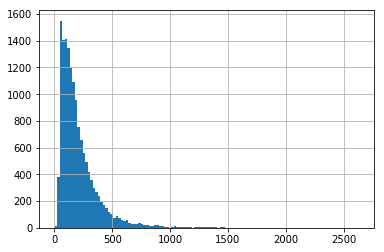

In [11]:
len_text = banks['text'].apply(lambda x: len(x.split()))
len_text.hist(bins=120)

In [12]:
len_text.describe()

count    15000.000000
mean       210.946400
std        178.910863
min          4.000000
25%         98.000000
50%        161.000000
75%        263.000000
max       2631.000000
Name: text, dtype: float64

### Длины текстов в символах

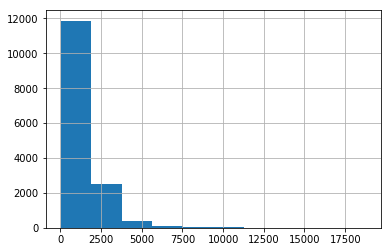

In [13]:
len_text = banks['text'].apply(len)
len_text.hist()

In [14]:
len_text.describe()

count    15000.000000
mean      1391.869800
std       1187.511665
min         41.000000
25%        649.750000
50%       1056.000000
75%       1724.250000
max      18734.000000
Name: text, dtype: float64

In [15]:
import re
word = re.compile('[А-Яа-я]+')

In [16]:
banks['words_from_text'] = banks['text'].apply(lambda x: ' '.join(re.findall(word, x.lower())))
banks['words_from_text'][:10]

0    добрый день я не являюсь клиентом банка и пору...
1    доброго дня являюсь держателем зарплатной карт...
2    здравствуйте дублирую свое заявление от в до м...
3    добрый день я открыл расчетный счет в сбербанк...
4    г взяла кредит в вашем банке заявленная мною с...
5    я как и многие вкладчики открыл на руб со счас...
6    здравствуйте подал заявление на получение уэк ...
7    был крайне удивл н новостью от мая об унификац...
8    сотрудники банка восточный систематически сооб...
9    добрый день являюсь заемщиком в банке втб боле...
Name: words_from_text, dtype: object

### TOP-10 слов

In [17]:
cnt = collections.Counter()
n_types = []
n_tokens = []
tokens = []
sum_tokens = 0
for index, row in tqdm(banks.iterrows(), total = len(banks)):
    tokens = row['words_from_text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    for i in cnt.values(): # sum(cnt.values()) - это почему то не работала
        sum_tokens += i
    n_tokens.append(sum_tokens)
for i in cnt.most_common(10):
    print(i)


('в', 114420)
('и', 91736)
('не', 75551)
('на', 61944)
('что', 54820)
('я', 51069)
('с', 43021)
('по', 34309)
('мне', 28407)
('банка', 26197)


### Закон Ципфа

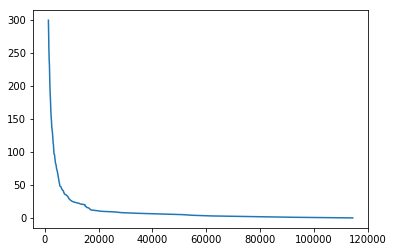

In [18]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

plt.plot(freqs[:300], range(300))

### Закон Хипса

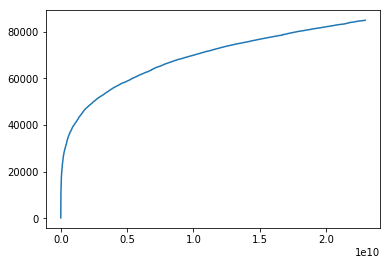

In [19]:
plt.plot(n_tokens, n_types)

### TOP-10 слов за исключением стоп слов

In [20]:
'''TOP-10 слов за исключением стоп слов'''
from nltk.corpus import stopwords
stopw = stopwords.words('russian')

In [21]:
def  stop_words(text, stopwords = stopw):
    try:
        return " ".join([token for token in text.split() if not token in stopwords and len(token) > 2])
    except:
        return ""

In [22]:
banks['words_from_text'] = banks['words_from_text'].apply(lambda token: stop_words(token)) 

In [23]:
cnt_2 = collections.Counter()
for index, row in tqdm(banks.iterrows(), total = len(banks)):
    tokens = row['words_from_text'].split()
    cnt_2.update(tokens)
for i in cnt_2.most_common(10):
    print(i)


('банка', 26197)
('банк', 21025)
('это', 15374)
('деньги', 10789)
('карты', 8893)
('карту', 8414)
('день', 7156)
('кредит', 6862)
('банке', 6399)
('заявление', 6143)


### TOP-10 лемм

In [24]:
'''TOP-10 лемм'''
from pymorphy2 import MorphAnalyzer
pm2 = MorphAnalyzer()

def  remove_lemm(text):
    try:
        return " ".join([pm2.parse(token)[0].normal_form for token in text.split()])
    except:
        return ""

In [25]:
banks['words_from_text'] = banks['words_from_text'].apply(lambda token: remove_lemm(token)) 

In [26]:
cnt_3 = collections.Counter()
for index, row in tqdm(banks.iterrows(), total = len(banks)):
    tokens = row['words_from_text'].split()
    cnt_3.update(tokens)
for i in cnt_3.most_common(10):
    print(i)


('банка', 37196)
('карта', 28032)
('банк', 25911)
('это', 17540)
('мой', 15610)
('день', 14937)
('деньга', 14577)
('кредит', 14235)
('сотрудник', 14041)
('который', 13690)


### TOP-10 существительных

In [27]:
top_100 = []
for i in cnt_3.most_common(100):
    top_100.append(i[0])

In [28]:
list(filter(lambda word: pm2.parse(word)[0].tag.POS == 'NOUN', top_100))[:10]

['банка',
 'карта',
 'банк',
 'день',
 'деньга',
 'кредит',
 'сотрудник',
 'клиент',
 'счёт',
 'отделение']

 какое слово встречается чаще, "сотрудник" или "клиент"?
 
 сколько раз встречается слова "мошенничество" и "доверие"?

In [29]:
employee = 0
customer = 0
fraud = 0
trust = 0
for index, row in tqdm(banks.iterrows(), total = len(banks)):
    words = row['words_from_text'].split()
    for i in words: # не очень грамотно делать столько циклов, но работет быстро
        if i == "сотрудник":
            employee += 1
        elif i == 'клиент':
            customer += 1
        elif i == "мошенничество":
            fraud += 1
        elif i == 'доверие':
            trust += 1

print ("сотрудник:", employee, '\t', "клиент:", customer)
print ("мошенничество:", fraud, '\t', "доверие:", trust)


сотрудник: 14041 	 клиент: 12108
мошенничество: 323 	 доверие: 213


В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру 𝑡𝑓−𝑖𝑑𝑓, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [30]:
banks['words_from_text'] = banks['words_from_text'].apply(lambda x: x.split())
neg = banks['words_from_text'][banks['rating_grade']==1][:900]
pos = banks['words_from_text'][banks['rating_grade']==5]

### для отрицательных отзывов

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in neg])

In [32]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in neg])
feature_names = tfidf.get_feature_names() 
tfidf_ranking = []
dense = tfidf_matrix.todense()

text = dense[10].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)
    
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,письмо отказ
1,банка техносёл
2,взять неделя
3,ждать своевременный
4,который молча
5,молча навязать
6,момент кредит
7,назад номер
8,необходимый приложить
9,нужно отправить


### для положительных отзывов

In [33]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in pos])
feature_names = tfidf.get_feature_names() 
tfidf_ranking = []
dense = tfidf_matrix.todense()

text = dense[10].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)
    
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,кошелёк
1,просить
2,перевод
3,процедура
4,анализ
5,тикета
6,привязка
7,идентифицировать
8,сим
9,утеря


In [34]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in pos])
feature_names = tfidf.get_feature_names() 
tfidf_ranking = []
dense = tfidf_matrix.todense()

text = dense[10].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)
    
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,анализ транзакция
1,благодарный пока
2,больший оборот
3,весь требовать
4,владение два
5,возможность восстановление
6,восстановление мой
7,два кошелёк
8,документ перевод
9,знать сталкиваться


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [35]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [36]:
example = banks['words_from_text'].tolist()


In [37]:
tfidf = TfidfVectorizer(analyzer='word', min_df = 15)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in example])

In [38]:
dictionary = Dictionary(example)
corpus = [dictionary.doc2bow(text) for text in example]

In [39]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [40]:
from gensim.models import lsimodel, ldamodel
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lsi.show_topics(5)

[(0,
  '0.188*"карта" + 0.134*"кредит" + 0.115*"деньга" + 0.109*"вклад" + 0.108*"рубль" + 0.108*"заявление" + 0.106*"счёт" + 0.101*"сумма" + 0.097*"сотрудник" + 0.097*"отделение"'),
 (1,
  '-0.247*"звонок" + -0.234*"номер" + 0.220*"вклад" + 0.211*"карта" + -0.188*"кредит" + -0.167*"ваш" + -0.151*"персональный" + -0.147*"поступать" + -0.143*"телефон" + -0.142*"база"'),
 (2,
  '-0.605*"вклад" + 0.224*"карта" + 0.170*"банкомат" + 0.165*"сбербанк" + -0.151*"договор" + -0.138*"ставка" + -0.130*"процент" + -0.128*"страховка" + -0.121*"условие" + 0.112*"операция"'),
 (3,
  '-0.321*"вклад" + 0.310*"кредит" + 0.298*"страховка" + 0.207*"страхование" + -0.178*"номер" + 0.163*"платёж" + 0.160*"погашение" + 0.136*"сумма" + 0.129*"досрочный" + 0.121*"договор"'),
 (4,
  '0.198*"средство" + 0.197*"вклад" + 0.195*"рубль" + 0.185*"договор" + -0.167*"заявка" + 0.166*"денежный" + 0.163*"сумма" + 0.158*"комиссия" + 0.136*"счёт" + -0.119*"отделение"')]

так как lsi модель показывает и положительный вклад слов в тему и отрицательный, то это менее интерпритируемо чем lda

In [41]:
lda_1 = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=8,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)
lda_1.show_topics(8)

[(0,
  '0.003*"полис" + 0.003*"долларовый" + 0.002*"каско" + 0.002*"бабушка" + 0.002*"доброжелательный" + 0.002*"терпеть" + 0.002*"претензионный" + 0.002*"напоминание" + 0.002*"кормить" + 0.002*"уволиться"'),
 (1,
  '0.000*"сдм" + 0.000*"венера" + 0.000*"чдг" + 0.000*"гурин" + 0.000*"раис" + 0.000*"петра" + 0.000*"балашиха" + 0.000*"дсбть" + 0.000*"дубравный" + 0.000*"замедленно"'),
 (2,
  '0.000*"свекровь" + 0.000*"маста" + 0.000*"суперставка" + 0.000*"гута" + 0.000*"смартбанк" + 0.000*"юнистрим" + 0.000*"сосудистый" + 0.000*"дистония" + 0.000*"елизавета" + 0.000*"бит"'),
 (3,
  '0.000*"лайм" + 0.000*"руссколлектор" + 0.000*"хард" + 0.000*"первобанка" + 0.000*"покровка" + 0.000*"коллекшн" + 0.000*"косметолог" + 0.000*"медлицензия" + 0.000*"базис" + 0.000*"омс"'),
 (4,
  '0.001*"бат" + 0.000*"тайский" + 0.000*"рапид" + 0.000*"росевробанк" + 0.000*"богдан" + 0.000*"трек" + 0.000*"хмельницкий" + 0.000*"лукойл" + 0.000*"дельта" + 0.000*"ступино"'),
 (5,
  '0.005*"григорьев" + 0.004*"цбрф"

Очень раскиданы слова по топикам и сложно выделить конкретную тему

In [42]:
lda_2 = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)
lda_2.show_topics(4)

[(0,
  '0.000*"лизингополучатель" + 0.000*"лизинговый" + 0.000*"инкассовый" + 0.000*"неперечисление" + 0.000*"лизингодатель" + 0.000*"лизинг" + 0.000*"сдм" + 0.000*"райф" + 0.000*"лукойл" + 0.000*"башкирский"'),
 (1,
  '0.000*"монета" + 0.000*"сергиев" + 0.000*"мироед" + 0.000*"венгр" + 0.000*"посуда" + 0.000*"сирота" + 0.000*"башкирский" + 0.000*"башг" + 0.000*"хранилище" + 0.000*"ротозейство"'),
 (2,
  '0.009*"удалить" + 0.007*"обзвон" + 0.006*"адресовать" + 0.005*"мероприятие" + 0.005*"проделать" + 0.004*"прекратиться" + 0.003*"роскомнадзор" + 0.003*"пётр" + 0.003*"обработка" + 0.002*"персональный"'),
 (3,
  '0.004*"карта" + 0.003*"кредит" + 0.003*"вклад" + 0.003*"деньга" + 0.002*"счёт" + 0.002*"рубль" + 0.002*"номер" + 0.002*"отделение" + 0.002*"заявление" + 0.002*"сотрудник"')]

В зависимости от построени модели, но иногда чётко выделяются темы (вклады и счеты, лизинг, очередь в отделения банка)

Теперь найдем отзывы в котором упомянуты банки (Сбербанк и ВТБ)

In [62]:
# Возьмем выборку по больше, что бы отзывов с банками тоже попало больше
banks_ = pd.DataFrame(index=range(50000), columns=['text'])
for response, ind in tqdm(zip(responses_[:50000], range(len(responses_[:50000])))):
    banks_['text'].iloc[ind] = response['text']

In [67]:
df_banks_ = pd.DataFrame(banks_['text'].apply(lambda x: ' '.join(re.findall(word, x.lower()))))
df_banks_['text'] = df_banks_['text'].apply(lambda token: stop_words(token)) 
df_banks_['text'] = df_banks_['text'].apply(lambda token: remove_lemm(token)) 
df_banks_.head(3)

,text
0,добрый день являться клиент банка поручитель к...
1,добрый день являться держатель зарплатный карт...
2,здравствовать дублировать свой заявление можай...


In [68]:
import re
pattern = re.compile('втб')
pattern_2 = re.compile('сбербанк')

In [69]:
values_index = []
for num, row in tqdm(banks_.iterrows(), total = len(banks_)):
    result = re.search(pattern, row['text'])
    result_2 = re.search(pattern_2, row['text'])
    if result != None or result_2 != None:
        values_index.append(num)

In [70]:
df_banks_['text'][df_banks_.index.isin(values_index)] = df_banks_['text'].apply(lambda x: x.split())

In [71]:
example_2 = df_banks_['text'][df_banks_.index.isin(values_index)].tolist()

In [76]:
tfidf = TfidfVectorizer(analyzer='word', min_df = 15)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in example_2])

In [77]:
dictionary = Dictionary(example_2)
corpus = [dictionary.doc2bow(text) for text in example_2]

In [78]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [79]:
lda_3 = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5,
                        alpha='auto', eta='auto', iterations = 40, passes = 8)
lda_3.show_topics(5)

[(0,
  '0.004*"карта" + 0.003*"заявление" + 0.003*"деньга" + 0.003*"кредит" + 0.002*"номер" + 0.002*"счёт" + 0.002*"рубль" + 0.002*"отделение" + 0.002*"средство" + 0.002*"банкомат"'),
 (1,
  '0.002*"страхование" + 0.002*"окно" + 0.001*"талон" + 0.001*"очередь" + 0.001*"закладная" + 0.001*"полис" + 0.001*"квартира" + 0.001*"поручитель" + 0.001*"монета" + 0.001*"одобрить"'),
 (2,
  '0.001*"бти" + 0.000*"светланский" + 0.000*"зельгросс" + 0.000*"благовещенск" + 0.000*"травма" + 0.000*"боровский" + 0.000*"рассказовка" + 0.000*"хны" + 0.000*"спокойненький" + 0.000*"салютный"'),
 (3,
  '0.000*"станкозаводский" + 0.000*"агрессивно" + 0.000*"духовный" + 0.000*"высокомерно" + 0.000*"деликатность" + 0.000*"растаять" + 0.000*"замениться" + 0.000*"тёрка" + 0.000*"базар" + 0.000*"переходящий"'),
 (4,
  '0.000*"котировка" + 0.000*"омс" + 0.000*"пообщий" + 0.000*"золото" + 0.000*"всеволожск" + 0.000*"неизмеримый" + 0.000*"тож" + 0.000*"финик" + 0.000*"телефонк" + 0.000*"инкассо"')]

### Вывод
Даже делая выборку из отзывов где есть упоминание сбербанка и втб, эти слова не вносят ощутимый вклад в тему. Единственное можно заметить, что есть тема про очереди в отделениях

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [80]:
positive = []
negative = []
for response in tqdm(responses_):
    rating = response['rating_grade']
    if rating == 1:
        negative.append(response)
    elif rating == 5:
        positive.append(response)

In [81]:
len(positive), len(negative)

(14713, 47387)

для равновесия и более быстрого просчета возьмем по 5000 негативных и позитивных примеров

In [82]:
df = pd.DataFrame(index=range(10000), columns=['text', 'target'])

count = 0
while count < 5000:
    df['text'].iloc[count] = positive[count]['text']
    df['target'].iloc[count] = positive[count]['rating_grade']
    count += 1

In [83]:
count = 0
while count < 5000:
    df['text'].iloc[count+5000] = negative[count]['text']
    df['target'].iloc[count+5000] = negative[count]['rating_grade']
    count += 1

In [84]:
df['text'] = df['text'].apply(lambda x: ' '.join(re.findall(word, x.lower())))
df['text'] = df['text'].apply(lambda token: stop_words(token))
df['text'] = df['text'].apply(lambda token: remove_lemm(token)) 

In [85]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

### Строим модель с использованием униграмм

In [86]:
df_uni = df.copy()

In [87]:
df_list = df_uni['text'].tolist()
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 50)
df_tfidf = tfidf.fit_transform(df_list)

In [88]:
df_tfidf.toarray().shape

(10000, 2687)

In [89]:
for i in tqdm(range(df_tfidf.shape[1])):
    col_name = 'd{}'.format(i)
    df_uni[col_name] = pd.Series(df_tfidf.toarray()[:, i])

In [90]:
df_uni = df_uni.drop('text', axis=1)

In [91]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 13)

for train_index, test_index in splitter.split(df_uni, df_uni['target']):
    X_train = df_uni.iloc[train_index]
    X_test = df_uni.iloc[test_index]
    y_train = df_uni['target'].iloc[train_index]
    y_test = df_uni['target'].iloc[test_index]

In [92]:
X_train = X_train.drop('target', axis=1)
X_test = X_test.drop('target', axis=1)

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [94]:
logist = LogisticRegression(n_jobs=-1)

In [95]:
grid_params = {'penalty': ['l2', 'l1'], 'C': [ 0.05, 0.1, 0.5, 1, 1.5, 2]}
grid_log = GridSearchCV(logist, grid_params, cv=5, n_jobs=-1)

In [96]:
grid_log.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [0.05, 0.1, 0.5, 1, 1.5, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
grid_log.best_params_

{'C': 1.5, 'penalty': 'l2'}

In [98]:
grid_log.best_estimator_.fit(X_train, y_train)
y_pred = grid_log.predict(X_test)

In [99]:
from sklearn.metrics import accuracy_score, f1_score

In [100]:
accuracy_score(y_test, y_pred)

0.9455

In [101]:
f1_score(y_test, y_pred)

0.9469586374695863

### Строим модель с использованием биграмм

In [102]:
df_bi = df.copy()

In [103]:
df_list = df_bi['text'].tolist()
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 50)
df_tfidf = tfidf.fit_transform(df_list)

In [104]:
df_tfidf.toarray().shape

(10000, 1699)

In [105]:
for i in tqdm(range(df_tfidf.shape[1])):
    col_name = 'd{}'.format(i)
    df_bi[col_name] = pd.Series(df_tfidf.toarray()[:, i])

In [106]:
df_bi = df_bi.drop('text', axis=1)

In [107]:
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 13)

for train_index, test_index in splitter.split(df_bi, df_bi['target']):
    X_train = df_bi.iloc[train_index]
    X_test = df_bi.iloc[test_index]
    y_train = df_bi['target'].iloc[train_index]
    y_test = df_bi['target'].iloc[test_index]

In [108]:
X_train = X_train.drop('target', axis=1)
X_test = X_test.drop('target', axis=1)

In [109]:
logist = LogisticRegression(n_jobs=-1)

In [110]:
grid_params = {'penalty': ['l2', 'l1'], 'C': [ 0.05, 0.1, 0.5, 1, 1.5, 2]}
grid_log = GridSearchCV(logist, grid_params, cv=5, n_jobs=-1)

In [111]:
grid_log.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [0.05, 0.1, 0.5, 1, 1.5, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [112]:
grid_log.best_params_

{'C': 1, 'penalty': 'l2'}

In [113]:
grid_log.best_estimator_.fit(X_train, y_train)
y_pred = grid_log.predict(X_test)

In [114]:
accuracy_score(y_test, y_pred)

0.8815

In [115]:
f1_score(y_test, y_pred)

0.8854519091348478

### Строим модель с использованием триграмм

In [116]:
df_tree = df.copy()

In [117]:
df_list = df_tree['text'].tolist()
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(3,3), min_df = 30)
df_tfidf = tfidf.fit_transform(df_list)

In [118]:
df_tfidf.toarray().shape

(10000, 272)

In [119]:
for i in tqdm(range(df_tfidf.shape[1])):
    col_name = 'd{}'.format(i)
    df_tree[col_name] = pd.Series(df_tfidf.toarray()[:, i])

In [120]:
df_tree = df_tree.drop('text', axis=1)

In [121]:
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 13)

for train_index, test_index in splitter.split(df_tree, df_tree['target']):
    X_train = df_tree.iloc[train_index]
    X_test = df_tree.iloc[test_index]
    y_train = df_tree['target'].iloc[train_index]
    y_test = df_tree['target'].iloc[test_index]

In [122]:
X_train = X_train.drop('target', axis=1)
X_test = X_test.drop('target', axis=1)

In [123]:
logist = LogisticRegression(n_jobs=-1)

In [124]:
grid_params = {'penalty': ['l2', 'l1'], 'C': [ 0.05, 0.1, 0.5, 1, 1.5, 2]}
grid_log = GridSearchCV(logist, grid_params, cv=5, n_jobs=-1)

In [125]:
grid_log.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [0.05, 0.1, 0.5, 1, 1.5, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [126]:
grid_log.best_params_

{'C': 0.05, 'penalty': 'l2'}

In [127]:
grid_log.best_estimator_.fit(X_train, y_train)
y_pred = grid_log.predict(X_test)

In [128]:
accuracy_score(y_test, y_pred)

0.675

In [129]:
f1_score(y_test, y_pred)

0.731404958677686

### Вывод
Видим что классификация на униграммах самая точная

### теперь попробуем при помощи скрытых признаков

In [130]:
from sklearn.decomposition import TruncatedSVD

In [131]:
data = df.copy()

In [132]:
df_list = data['text'].tolist()
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 50)
df_tfidf = tfidf.fit_transform(df_list)

In [133]:
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(df_tfidf)

In [134]:
for num in range(5):
    data['hidden_feature{}'.format(num)] = X_reduced[:, num]

Сначала сделаем классификацию только на скрытых факторах

In [135]:
data_ = data.drop('text', axis=1)

In [136]:
data_.head()

,target,hidden_feature0,hidden_feature1,hidden_feature2,hidden_feature3,hidden_feature4
0,5,0.188351,0.215681,-0.025478,0.154653,0.106574
1,5,0.315352,0.280516,-0.167288,0.310078,0.229691
2,5,0.245552,0.119584,-0.040761,-0.081025,-0.048054
3,5,0.201697,0.168225,-0.060062,-0.046952,-0.030100
4,5,0.362267,0.057961,0.226708,-0.049088,0.150303


In [137]:
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 13)

for train_index, test_index in splitter.split(data_, data_['target']):
    X_train = data_.iloc[train_index]
    X_test = data_.iloc[test_index]
    y_train = data_['target'].iloc[train_index]
    y_test = data_['target'].iloc[test_index]

In [138]:
X_train = X_train.drop('target', axis=1)
X_test = X_test.drop('target', axis=1)

In [139]:
logist = LogisticRegression(penalty='l2', n_jobs=-1)

In [140]:
logist.fit(X_train, y_train)
y_pred = logist.predict(X_test)

In [141]:
accuracy_score(y_test, y_pred)

0.8145

In [142]:
f1_score(y_test, y_pred)

0.8175110673880963

теперь попробуем скрытые признаки с представлениями слов

In [143]:
data.head()

,text,target,hidden_feature0,hidden_feature1,hidden_feature2,hidden_feature3,hidden_feature4
0,досрочно закрывать вклад отпуск жена заказыват...,5,0.188351,0.215681,-0.025478,0.154653,0.106574
1,хотеть открыть вклад доходный год процент начи...,5,0.315352,0.280516,-0.167288,0.310078,0.229691
2,вчера июнь просидеть очередь часы получение ст...,5,0.245552,0.119584,-0.040761,-0.081025,-0.048054
3,сегодня открывать вклад банка очередь один кли...,5,0.201697,0.168225,-0.060062,-0.046952,-0.030100
4,история получение кредит ренессанс кредит банк...,5,0.362267,0.057961,0.226708,-0.049088,0.150303


In [144]:
df_list = data['text'].tolist()
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 50)
df_tfidf = tfidf.fit_transform(df_list)

In [145]:
for i in tqdm(range(df_tfidf.shape[1])):
    col_name = 'd{}'.format(i)
    data[col_name] = pd.Series(df_tfidf.toarray()[:, i])

In [146]:
data = data.drop('text', axis=1)

In [147]:
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 13)

for train_index, test_index in splitter.split(data, data['target']):
    X_train = data.iloc[train_index]
    X_test = data.iloc[test_index]
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

In [148]:
X_train = X_train.drop('target', axis=1)
X_test = X_test.drop('target', axis=1)

In [149]:
logist = LogisticRegression(n_jobs=-1)

In [150]:
logist.fit(X_train, y_train)
y_pred = logist.predict(X_test)

In [151]:
accuracy_score(y_test, y_pred)

0.9415

In [152]:
f1_score(y_test, y_pred)

0.9430656934306569

### Вывод
Видим что результат практически такой же как и без выделения скрытых тем

Теперь попробуем построить модель на LDA разложении

In [193]:
df_end = df.copy()

In [194]:
df_end['text'] = df_end['text'].apply(lambda x: x.split())

In [195]:
example = df_end['text'].tolist()

In [196]:
dictionary = Dictionary(example)
corpus = [dictionary.doc2bow(text) for text in example]

In [197]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [198]:
lda = ldamodel.LdaModel(corpus=corpus_tfidf , id2word=dictionary, num_topics=8,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

In [199]:
result = lda.do_estep(corpus_tfidf)

In [200]:
result.shape

(10000, 8)

In [201]:
for num in range(result.shape[1]):
    df_end['hidden_feature{}'.format(num)] = result[:, num]

In [218]:
df_end = df_end.drop('text', axis=1)
df_end.head()

,target,hidden_feature0,hidden_feature1,hidden_feature2,hidden_feature3,hidden_feature4,hidden_feature5,hidden_feature6,hidden_feature7
0,5,0.264655,0.055326,0.062417,20.643383,0.051976,0.055514,0.227958,0.067715
1,5,0.264652,0.055326,0.062417,21.930553,0.051976,0.055514,0.227956,0.067715
2,5,0.264661,0.055326,0.062417,22.015701,0.051976,0.055514,0.466666,0.067715
3,5,0.264779,0.055326,0.062417,21.357742,0.051976,0.055514,0.437102,0.067715
4,5,0.264877,0.055326,0.062417,25.688366,0.051976,0.055514,0.228079,0.067715


In [229]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [230]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 13)

for train_index, test_index in splitter.split(df_end, df_end['target']):
    X_train = df_end.iloc[train_index]
    X_test = df_end.iloc[test_index]
    y_train = df_end['target'].iloc[train_index]
    y_test = df_end['target'].iloc[test_index]

In [231]:
X_train = X_train.drop('target', axis=1)
X_test = X_test.drop('target', axis=1)

In [235]:
X_train_sc = std.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc, columns=X_train.columns)

X_test_sc = std.transform(X_test)
X_test = pd.DataFrame(X_test_sc, columns=X_train.columns)

In [266]:
logist = LogisticRegression(penalty='l2', C=1e-3, n_jobs=-1)

In [267]:
logist.fit(X_train, y_train)
y_pred = logist.predict(X_test)

In [268]:
accuracy_score(y_test, y_pred)

0.5325

In [269]:
f1_score(y_test, y_pred)

0.5908096280087527

### Вывод
Странно, но получили совсем плохие результаты